In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import pickle
import mgzip
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
import pyreadr
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

tqdm.pandas()

/opt/homebrew/Caskroom/miniforge/base/envs/NLP_thesis_new/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Choose file we want to predict

In [3]:
with mgzip.open('../data/predict_bert_notopic.mgzip', 'rb') as handle:
    predict = pickle.load(handle)
#predict.to_csv('../data/predict_bert_topic.csv')

In [4]:
predict

,date,newspaper,avg_length_sent,avg_length,count_adj,count_nn,percent_adj,percent_nn,drosten,kekulé,...,vec94,vec95,vec96,vec97,vec98,vec99,readability,bert_score,bert_label,count
0,20211130,zeit,132,12.931818,99,308,0.159420,0.495974,0,0,...,-0.161960,0.248903,0.074645,0.301991,-0.056559,-0.110715,67.55,-0.534319,negative,16.0
1,20211130,zeit,45,17.200000,57,177,0.182692,0.567308,0,0,...,-0.177319,0.168344,0.054985,0.361732,0.097123,-0.214455,40.35,-0.144371,negative,26.0
2,20211130,zeit,47,14.638298,62,136,0.185075,0.405970,0,0,...,-0.171513,0.226778,0.081598,0.405015,0.218751,-0.101342,51.20,-0.370915,neutral,80.0
3,20211130,zeit,27,17.703704,37,118,0.171296,0.546296,0,0,...,-0.169155,0.158914,-0.018662,0.361970,-0.023742,-0.212981,33.60,-0.469456,negative,89.0
4,20211129,zeit,23,17.000000,25,96,0.154321,0.592593,0,0,...,-0.162320,0.137992,-0.046678,0.246300,0.144182,-0.273458,39.45,-0.436324,neutral,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28446,20200120,tagespiegel,38,17.315789,39,110,0.170306,0.480349,0,0,...,-0.216498,-0.007052,0.045049,0.277643,0.213910,-0.273728,53.65,-0.992965,negative,1.0
28447,20200120,tagespiegel,40,13.325000,46,133,0.183267,0.529880,0,0,...,-0.120381,0.059885,0.017755,0.349302,0.235176,-0.170969,49.30,0.045299,neutral,1.0
28448,20200119,tagespiegel,49,15.693878,50,175,0.145349,0.508721,0,0,...,-0.128967,0.081093,-0.001197,0.386025,0.200805,-0.148846,52.85,-0.059480,neutral,2.0
28451,20200109,tagespiegel,39,15.769231,46,148,0.159722,0.513889,0,0,...,-0.147792,0.045513,0.061079,0.356137,0.204371,-0.213621,41.75,-0.893052,negative,1.0


In [345]:
X = predict
X = X.dropna()
X[['tagespiegel', 'welt', 'zeit']] = pd.get_dummies(X['newspaper'])
X.drop('newspaper', inplace=True, axis=1)

/var/folders/06/ng7ccz8d4fdfcgp2wp0g434w0000gn/T/ipykernel_16526/3869162192.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['tagespiegel', 'welt', 'zeit']] = pd.get_dummies(X['newspaper'])
/var/folders/06/ng7ccz8d4fdfcgp2wp0g434w0000gn/T/ipykernel_16526/3869162192.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['tagespiegel', 'welt', 'zeit']] = pd.get_dummies(X['newspaper'])
/var/folders/06/ng7ccz8d4fdfcgp2wp0g434w0000gn/T/ipykernel_16526/3869162192.py:3: SettingWithCopyWarning: 
A value is tr

#### Continuous labels

In [346]:
y = X['bert_score']
X.drop(['bert_score', 'bert_label'], axis=1, inplace=True)

/var/folders/06/ng7ccz8d4fdfcgp2wp0g434w0000gn/T/ipykernel_16526/2893972162.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(['bert_score', 'bert_label'], axis=1, inplace=True)


In [347]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

##### Create baseline value using linear regression

In [262]:
regr = LinearRegression()
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

0.06330454354398718

In [263]:
scores_lin_reg_r2 = cross_val_score(regr, X_test, y_test, cv=5)

In [264]:
scores_lin_reg_r2.mean()

0.05380120697119688

In [265]:
scores_lin_reg_mae = cross_val_score(regr, X_test, y_test, cv=5, scoring=make_scorer(mean_absolute_error))

In [266]:
scores_lin_reg_mae.mean()

0.1763230076929804

R2 is 6%, MAE is 0.174

In [168]:
pred_lin_reg = regr.predict(X_test)

##### Try ensemble random forest regressor
Grid search for parameter tuning, cross validation: 5

In [33]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20 , cv = 3, verbose = 1, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)

rf_random.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/homebrew/Caskroom/miniforge/base/envs/NLP_thesis_new/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': False}

In [348]:
regr = RandomForestRegressor(n_jobs = -1, n_estimators = 1200, min_samples_split = 2, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 90, bootstrap = False)
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

0.09325939954341433

In [121]:
scores_rfr_r2 = cross_val_score(regr, X_test, y_test, cv=5)

In [122]:
scores_rfr_r2.mean()

0.08661176802954196

In [123]:
scores_rfr_mae = cross_val_score(regr, X_test, y_test, cv=5, scoring=make_scorer(mean_absolute_error))

In [124]:
scores_rfr_mae.mean()

0.17054942148384925

R2 is 9.3%, MAE is 0.169

In [171]:
pred_rf = regr.predict(X_test)

Feature: 0, Score: 0.00757
Feature: 1, Score: 0.00870
Feature: 2, Score: 0.00814
Feature: 3, Score: 0.00772
Feature: 4, Score: 0.00794
Feature: 5, Score: 0.00713
Feature: 6, Score: 0.00876
Feature: 7, Score: 0.00009
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00004
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00926
Feature: 13, Score: 0.00721
Feature: 14, Score: 0.00799
Feature: 15, Score: 0.00945
Feature: 16, Score: 0.00798
Feature: 17, Score: 0.00738
Feature: 18, Score: 0.00844
Feature: 19, Score: 0.00876
Feature: 20, Score: 0.00948
Feature: 21, Score: 0.01063
Feature: 22, Score: 0.00876
Feature: 23, Score: 0.00985
Feature: 24, Score: 0.01505
Feature: 25, Score: 0.00806
Feature: 26, Score: 0.00820
Feature: 27, Score: 0.00790
Feature: 28, Score: 0.00935
Feature: 29, Score: 0.01118
Feature: 30, Score: 0.00873
Feature: 31, Score: 0.00850
Feature: 32, Score: 0.00807
Feature: 33, Score: 0.00791
Feature: 34, Score: 0.00803
Feature: 35, Score: 0.00887
Fe

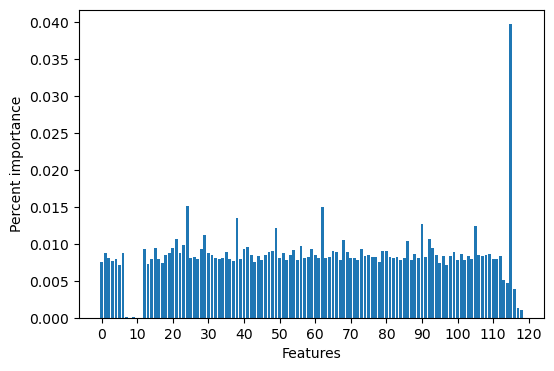

In [349]:
# get importance
importance = regr.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
fig, ax = plt.subplots()
plt.bar([x for x in range(len(importance))], importance)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 10))
plt.xlabel('Features')
plt.ylabel('Percent importance')
fig.set_figheight(4)
fig.set_figwidth(6)
plt.savefig('../figures/rfr_importance.png')

In [352]:
importance

array([7.57151474e-03, 8.70298869e-03, 8.14465591e-03, 7.71931328e-03,
       7.94043099e-03, 7.12806902e-03, 8.75800129e-03, 8.99677872e-05,
       2.12120010e-06, 4.34290200e-05, 2.78010805e-06, 0.00000000e+00,
       9.25958959e-03, 7.21122220e-03, 7.99223498e-03, 9.45306610e-03,
       7.97816789e-03, 7.38271401e-03, 8.44310391e-03, 8.76075663e-03,
       9.47915636e-03, 1.06274322e-02, 8.76466297e-03, 9.85254123e-03,
       1.50499431e-02, 8.06222549e-03, 8.20211978e-03, 7.90293121e-03,
       9.34627726e-03, 1.11786417e-02, 8.73011997e-03, 8.50024349e-03,
       8.06585289e-03, 7.90954051e-03, 8.03380333e-03, 8.86568818e-03,
       7.99961350e-03, 7.72812017e-03, 1.34707591e-02, 7.95836076e-03,
       9.29526414e-03, 9.58336578e-03, 8.46975214e-03, 7.57938782e-03,
       8.36174521e-03, 7.74313356e-03, 8.46922632e-03, 8.94974278e-03,
       8.96775301e-03, 1.21239467e-02, 8.01803625e-03, 8.75780011e-03,
       7.75723077e-03, 8.45669946e-03, 9.20787473e-03, 7.80155117e-03,
      

In [353]:
pd.Series(X_train.columns)

0                 date
1      avg_length_sent
2           avg_length
3            count_adj
4             count_nn
            ...       
114          top2vec_1
115              count
116        tagespiegel
117               welt
118               zeit
Length: 119, dtype: object

##### Try neural network
Rescaling of all features to 0-1 for better compatibility

In [172]:
scaler = StandardScaler() #MinMaxScaler
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)

In [39]:
regr = MLPRegressor(max_iter=2000)

In [40]:
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (119,119,62)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05, 0.001, 1],
    'learning_rate': ['constant','adaptive']
}

In [25]:
clf = GridSearchCV(regr, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train_norm, y_train)

GridSearchCV(cv=3, estimator=MLPRegressor(max_iter=2000), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05, 0.001, 1],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,), (119, 119, 62)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [26]:
# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'activation': 'relu', 'alpha': 1, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'sgd'}
-0.009 (+/-0.012) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
-0.924 (+/-0.169) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
-0.018 (+/-0.021) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
-0.925 (+/-0.275) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
-0.022 (+/-0.022) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
-0.899 (+/-0.207) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'ada

In [270]:
regr = MLPRegressor(max_iter=2000, activation='relu', alpha=1, hidden_layer_sizes=(100,), learning_rate='adaptive', solver='sgd')
regr.fit(X_train_norm, y_train)
regr.score(X_test_norm, y_test)

0.08129622939794345

In [127]:
scores_rnn_r2 = cross_val_score(regr, X_test_norm, y_test, cv=5)

In [128]:
scores_rnn_r2.mean()

0.0630103658537561

In [129]:
scores_rnn_mae = cross_val_score(regr, X_test_norm, y_test, cv=5, scoring=make_scorer(mean_absolute_error))

In [130]:
scores_rnn_mae.mean()

0.17443203966045465

R2 is 8%, MAE is 0.171

In [175]:
pred_rnn = regr.predict(X_test_norm)

In [271]:
from sklearn.inspection import permutation_importance
r = permutation_importance(regr, X_test_norm, y_test,
                           n_repeats=50,
                           random_state=0)



vec12   0.006 +/- 0.001
vec50   0.006 +/- 0.001
vec61   0.005 +/- 0.001
vec46   0.005 +/- 0.001
vec64   0.005 +/- 0.001
vec28   0.005 +/- 0.001
vec9    0.005 +/- 0.001
vec30   0.004 +/- 0.001
vec26   0.004 +/- 0.001
vec2    0.004 +/- 0.001
vec37   0.004 +/- 0.001
vec36   0.004 +/- 0.001
welt    0.003 +/- 0.001
vec18   0.003 +/- 0.001
vec75   0.003 +/- 0.001
vec16   0.003 +/- 0.001
vec67   0.003 +/- 0.001
vec10   0.003 +/- 0.001
vec6    0.003 +/- 0.001
vec93   0.003 +/- 0.001
readability0.002 +/- 0.001
vec56   0.002 +/- 0.001
vec81   0.002 +/- 0.001
vec7    0.002 +/- 0.001
vec41   0.002 +/- 0.000
vec94   0.002 +/- 0.001
vec68   0.002 +/- 0.001
vec80   0.002 +/- 0.001
vec53   0.002 +/- 0.001
vec22   0.002 +/- 0.000
vec20   0.002 +/- 0.001
vec78   0.002 +/- 0.000
vec48   0.002 +/- 0.001
vec21   0.002 +/- 0.000
vec59   0.001 +/- 0.000
vec32   0.001 +/- 0.000
count_adj0.001 +/- 0.001
vec83   0.001 +/- 0.001
vec63   0.001 +/- 0.000
vec65   0.001 +/- 0.000
vec39   0.001 +/- 0.000
count   0.00

In [359]:
r.importances_mean

array([-1.27776391e-03, -2.86997754e-04,  8.56001997e-04, -9.60818568e-04,
        1.50486648e-03, -5.24082855e-05, -1.22286000e-03,  1.34764163e-04,
       -1.24781632e-05,  3.86823060e-04, -5.31569753e-04, -9.98253057e-05,
        7.98602446e-05,  1.82181183e-04,  4.03044672e-03,  1.99650611e-04,
       -6.08934365e-04,  5.56526079e-04,  4.15023709e-03,  1.73696032e-03,
        1.29772897e-03, -9.05914649e-04,  2.04392313e-03,  3.04966309e-03,
       -4.66683304e-04,  1.82929873e-03,  3.99301223e-04,  1.51235338e-03,
        1.52233591e-03, -1.24781632e-04,  1.29273771e-03,  1.52982281e-03,
       -6.56351385e-04,  4.81657100e-04,  2.54055403e-03, -7.13750936e-04,
       -2.79510856e-04,  3.02720240e-03,  1.15048665e-03,  1.07062640e-03,
        3.22685301e-03,  4.16271525e-03,  3.62116296e-03, -4.96630896e-04,
        1.60219616e-03,  1.03818318e-03, -5.29074120e-04, -2.86997754e-04,
        2.30846019e-03,  1.62465685e-03,  1.30771150e-03,  1.79935114e-03,
        1.06064387e-03,  

#### Categorical labels

In [5]:
X = predict
X = X.dropna()
X[['tagespiegel', 'welt', 'zeit']] = pd.get_dummies(X['newspaper'])
X.drop('newspaper', inplace=True, axis=1)
y = X['bert_label']
X.drop(['bert_score', 'bert_label'], axis=1, inplace=True)

/var/folders/06/ng7ccz8d4fdfcgp2wp0g434w0000gn/T/ipykernel_17676/526324045.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['tagespiegel', 'welt', 'zeit']] = pd.get_dummies(X['newspaper'])
/var/folders/06/ng7ccz8d4fdfcgp2wp0g434w0000gn/T/ipykernel_17676/526324045.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['tagespiegel', 'welt', 'zeit']] = pd.get_dummies(X['newspaper'])
/var/folders/06/ng7ccz8d4fdfcgp2wp0g434w0000gn/T/ipykernel_17676/526324045.py:3: SettingWithCopyWarning: 
A value is tryin

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

##### Create baseline value using logistic regression

In [7]:
regr = LogisticRegressionCV()
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

0.5686298976790617

In [136]:
scores_log_reg_acc = cross_val_score(regr, X_test, y_test, cv=5)

In [137]:
scores_log_reg_acc.mean()

0.5686299019550577

In [138]:
scores_log_reg_f1 = cross_val_score(regr, X_test, y_test, cv=5, scoring=make_scorer(f1_score, average='macro'))

In [139]:
scores_log_reg_f1.mean()

0.2416673172322173

Accuracy is 57%, F1 macro is 24.1%

In [140]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, regr.predict(X_test))

print(cf_matrix)

[[   0 3302    0]
 [   0 4557    0]
 [   0  155    0]]


In [182]:
pred_log_reg = regr.predict(X_test)

##### Try ensemble random forest classifier

In [122]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
criterion = ['gini', 'entropy']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
max_features = ['sqrt', 'log2', None]
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10 , cv = 3, verbose = 3, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)

rf_random.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 2/3] END bootstrap=False, criterion=gini, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.547 total time= 5.8min
[CV 2/3] END bootstrap=True, criterion=entropy, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000;, score=0.647 total time= 2.6min
[CV 3/3] END bootstrap=True, criterion=entropy, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1200;, score=0.652 total time= 2.8min
[CV 2/3] END bootstrap=True, criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=1400;, score=0.645 total time= 2.1min
[CV 3/3] END bootstrap=False, criterion=gini, max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.563 total time= 5.7min
[CV 1/3] END bootstrap=True, criterion=entropy, max_depth=100, max_features=

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': None,
 'max_depth': 80,
 'criterion': 'entropy',
 'bootstrap': True}

In [8]:
regr = RandomForestClassifier(n_jobs = -1, n_estimators = 200, min_samples_split = 10, min_samples_leaf = 4, max_features = None, max_depth = 80, criterion = 'entropy', bootstrap=True)
regr.fit(X_train,y_train)
regr.score(X_test,y_test)

0.6521088095832294

In [9]:
scores_rfc_acc = cross_val_score(regr, X_test, y_test, cv=5)

In [10]:
scores_rfc_acc.mean()

0.6367598829597749

In [11]:
scores_rfc_f1 = cross_val_score(regr, X_test, y_test, cv=5, scoring=make_scorer(f1_score, average='weighted'))

In [12]:
scores_rfc_f1.mean()

0.6170712897861783

Accuracy is 64.8%, F1 macro is 43.3%

In [341]:
pred_rf_clas = regr.predict(X_test)

In [342]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, pred_rf_clas)

print(cf_matrix)

[[1738 1564    0]
 [1104 3453    0]
 [  90   63    2]]


In [343]:
pd.Series(X_train.columns)

0                 date
1      avg_length_sent
2           avg_length
3            count_adj
4             count_nn
            ...       
114          top2vec_1
115              count
116        tagespiegel
117               welt
118               zeit
Length: 119, dtype: object

In [365]:
importance

array([9.81910850e-03, 7.66028731e-03, 1.07034765e-02, 6.51103725e-03,
       7.49882362e-03, 8.56782819e-03, 8.42728522e-03, 1.19817760e-04,
       6.69391994e-06, 9.84201535e-05, 0.00000000e+00, 0.00000000e+00,
       8.28861681e-03, 6.87771001e-03, 7.05093649e-03, 3.21611091e-02,
       1.29866660e-02, 7.20688623e-03, 7.44387019e-03, 7.49601184e-03,
       7.92796367e-03, 7.62836922e-03, 8.20610014e-03, 9.17200801e-03,
       1.13983053e-02, 8.07396848e-03, 8.11399358e-03, 7.00420348e-03,
       7.32846949e-03, 8.06295341e-03, 7.52612027e-03, 8.47287370e-03,
       8.40764866e-03, 8.60228979e-03, 9.50427507e-03, 8.51846941e-03,
       8.61141847e-03, 8.92995218e-03, 1.02296019e-02, 7.89504062e-03,
       1.05750940e-02, 9.76152854e-03, 9.41883650e-03, 7.12632677e-03,
       8.07681707e-03, 8.12247895e-03, 8.37174209e-03, 8.56537286e-03,
       7.63510373e-03, 8.85117038e-03, 7.43779841e-03, 8.36449010e-03,
       6.98149049e-03, 7.08896919e-03, 7.51557981e-03, 8.24703297e-03,
      

Feature: 0, Score: 0.00982
Feature: 1, Score: 0.00766
Feature: 2, Score: 0.01070
Feature: 3, Score: 0.00651
Feature: 4, Score: 0.00750
Feature: 5, Score: 0.00857
Feature: 6, Score: 0.00843
Feature: 7, Score: 0.00012
Feature: 8, Score: 0.00001
Feature: 9, Score: 0.00010
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00829
Feature: 13, Score: 0.00688
Feature: 14, Score: 0.00705
Feature: 15, Score: 0.03216
Feature: 16, Score: 0.01299
Feature: 17, Score: 0.00721
Feature: 18, Score: 0.00744
Feature: 19, Score: 0.00750
Feature: 20, Score: 0.00793
Feature: 21, Score: 0.00763
Feature: 22, Score: 0.00821
Feature: 23, Score: 0.00917
Feature: 24, Score: 0.01140
Feature: 25, Score: 0.00807
Feature: 26, Score: 0.00811
Feature: 27, Score: 0.00700
Feature: 28, Score: 0.00733
Feature: 29, Score: 0.00806
Feature: 30, Score: 0.00753
Feature: 31, Score: 0.00847
Feature: 32, Score: 0.00841
Feature: 33, Score: 0.00860
Feature: 34, Score: 0.00950
Feature: 35, Score: 0.00852
Fe

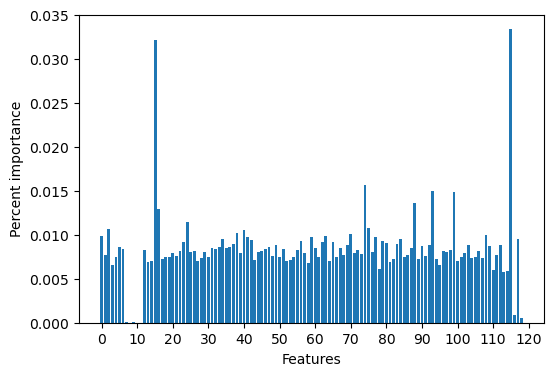

In [364]:
# get importance
importance = regr.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
fig, ax = plt.subplots()
plt.bar([x for x in range(len(importance))], importance)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 10))
plt.xlabel('Features')
plt.ylabel('Percent importance')
fig.set_figheight(4)
fig.set_figwidth(6)
plt.savefig('../figures/rfc_importance.png')

##### Try neural network

In [276]:
scaler = StandardScaler() #MinMaxScaler
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)

In [7]:
regr = MLPClassifier(max_iter=3000)

In [8]:
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (119,119,62)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05, 0.1,1],
    'learning_rate': ['constant','adaptive']
}

In [9]:
clf = GridSearchCV(regr, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train_norm, y_train)

GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=3000), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05, 0.1, 1],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,), (119, 119, 62)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [10]:
# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'activation': 'tanh', 'alpha': 1, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'sgd'}
0.565 (+/-0.011) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.568 (+/-0.014) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.565 (+/-0.016) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.561 (+/-0.011) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.566 (+/-0.010) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
0.579 (+/-0.016) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.

In [331]:
regr = MLPClassifier(max_iter=2000, activation='tanh', alpha=1, hidden_layer_sizes=(100,), learning_rate='constant', solver='sgd')
regr.fit(X_train_norm, y_train)
regr.score(X_test_norm, y_test)

0.6346393810831046

In [153]:
scores_cnn_acc = cross_val_score(regr, X_test_norm, y_test, cv=5)

In [154]:
scores_cnn_acc.mean()

0.6245308616880179

In [155]:
scores_cnn_f1 = cross_val_score(regr, X_test_norm, y_test, cv=5, scoring=make_scorer(f1_score, average='macro'))

In [156]:
scores_cnn_f1.mean()

0.41293375306572144

Accuracy is 63.9%, F1 macro is 39.1%

In [334]:
pred_cnn = regr.predict(X_test_norm)

In [335]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, regr.predict(X_test_norm))

print(cf_matrix)

[[1759 1543    0]
 [1229 3327    1]
 [  98   57    0]]


In [279]:
from sklearn.inspection import permutation_importance
r = permutation_importance(regr, X_test_norm, y_test,
                           n_repeats=50,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_train.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

vec81   0.005 +/- 0.002
welt    0.004 +/- 0.002
vec29   0.004 +/- 0.002
vec6    0.004 +/- 0.002
vec30   0.004 +/- 0.002
vec28   0.003 +/- 0.002
vec11   0.003 +/- 0.001
vec76   0.002 +/- 0.001


### Comparison graphs

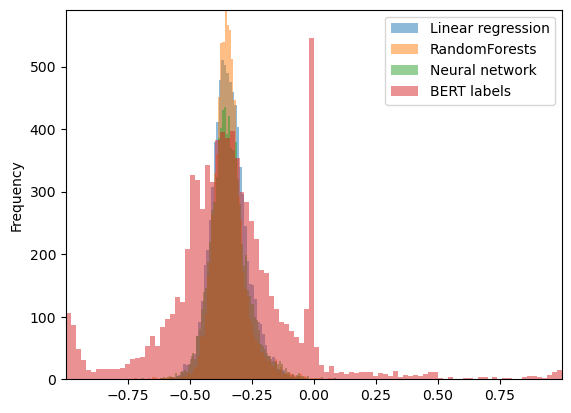

In [256]:
plt.margins(0)
plt.hist(pred_lin_reg, alpha=0.5, label='Linear regression', bins=100)
plt.hist(pred_rf, alpha=0.5, label='RandomForests', bins=100)
plt.hist(pred_rnn, alpha=0.5, label='Neural network', bins=100)
plt.hist(y_test, alpha=0.5, label='BERT labels', bins=100)
plt.legend()
plt.ylabel('Frequency')
plt.savefig('../figures/conti_predictions.png')

In [336]:
log_reg_counts = pd.Series([0, 8014, 0], index=['negative', 'neutral', 'positive'])
rf_counts = pd.Series(pred_rf_clas).value_counts()[['negative', 'neutral', 'positive']]
nn_counts = pd.Series(pred_cnn).value_counts()[['negative', 'neutral', 'positive']]
true_counts = pd.Series(y_test).value_counts()[['negative', 'neutral', 'positive']]
labels = ['negative', 'neutral', 'positive']

In [337]:
nn_counts

negative    3086
neutral     4927
positive       1
dtype: int64

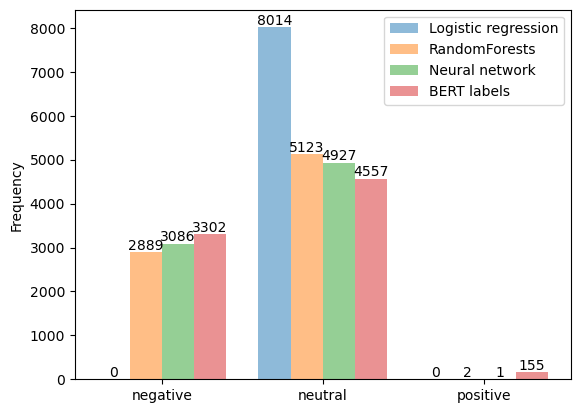

In [338]:
x = np.arange(len(labels))
width = 0.2
fig, ax = plt.subplots()
rects1 = ax.bar(x - 0.3, log_reg_counts, width, label='Logistic regression', alpha=0.5)
rects2 = ax.bar(x - 0.1, rf_counts, width, label='RandomForests', alpha=0.5)
rects3 = ax.bar(x + 0.1, nn_counts, width, label='Neural network', alpha=0.5)
rects4 = ax.bar(x + 0.3, true_counts, width, label='BERT labels', alpha=0.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1)
ax.bar_label(rects2)
ax.bar_label(rects3)
ax.bar_label(rects4)
plt.savefig('../figures/categorical_predictions.png')

In [159]:
regr_dict = {'Linear regression': list(scores_lin_reg_mae), 'RandomForests': list(scores_rfr_mae), 'Neural network': list(scores_rnn_mae)}

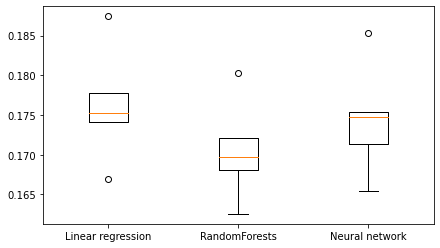

In [160]:
fig, ax = plt.subplots(figsize=(7,4))
ax.boxplot(regr_dict.values())
ax.set_xticklabels(regr_dict.keys())
plt.rcParams.update({'font.size':12})
plt.savefig('../figures/compare_regr.png')

In [161]:
clas_dict = {'Logistic regression': list(scores_log_reg_f1), 'RandomForests': list(scores_rfc_f1), 'Neural network': list(scores_cnn_f1)}

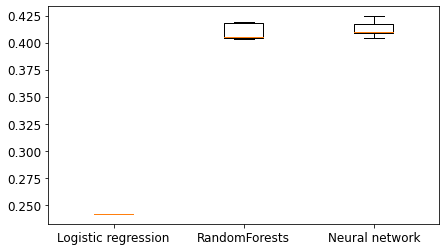

In [162]:
fig, ax = plt.subplots(figsize=(7,4))
ax.boxplot(clas_dict.values())
ax.set_xticklabels(clas_dict.keys())
plt.rcParams.update({'font.size': 12})
fig.savefig('../figures/compare_clas.png')